In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import numpy as np


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ---- SHIP vs NON-SHIP ----
# Filter ship and non-ship indices for train and test sets
ship_train_idx = np.where(y_train == 8)[0]
non_ship_train_idx = np.where(y_train != 8)[0]
ship_test_idx = np.where(y_test == 8)[0]
non_ship_test_idx = np.where(y_test != 8)[0]

# Balance the dataset
min_train = min(len(ship_train_idx), len(non_ship_train_idx))
min_test = min(len(ship_test_idx), len(non_ship_test_idx))

ship_train_idx = ship_train_idx[:min_train]
non_ship_train_idx = np.random.choice(non_ship_train_idx, size=min_train, replace=False)
ship_test_idx = ship_test_idx[:min_test]
non_ship_test_idx = np.random.choice(non_ship_test_idx, size=min_test, replace=False)

train_idx = np.concatenate([ship_train_idx, non_ship_train_idx])
test_idx = np.concatenate([ship_test_idx, non_ship_test_idx])
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

x_train_ship = x_train[train_idx].astype('float32') / 255.0
y_train_ship = (y_train[train_idx] == 8).astype(int)

x_test_ship = x_test[test_idx].astype('float32') / 255.0
y_test_ship = (y_test[test_idx] == 8).astype(int)

In [1]:

# Load CIFAR-10 data


# ---- Model Definition ----
model = Sequential([
    Input(shape=(32, 32, 3)),
    
    # More convolutional layers with smaller filters
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # Clip the prediction value to prevent log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Calculate focal weight
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), self.alpha, 1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        
        # Calculate focal loss
        focal_loss = alpha_factor * modulating_factor * cross_entropy
        
        return tf.reduce_mean(focal_loss)



model.compile(optimizer=Adam(1e-4), loss='FocalLoss(alpha=0.25, gamma=2.0)', metrics=['accuracy'])

# ---- Data Augmentation ----
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train_ship)
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 20:
        lr *= 0.5e-3
    elif epoch > 15:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
    return lr

# ---- Callbacks ----
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# ---- Train on ship vs non-ship ----
print("Training on ship vs non-ship images...")
history_ship = model.fit(
    datagen.flow(x_train_ship, y_train_ship, batch_size=32),
    epochs=30,
    validation_data=(x_test_ship, y_test_ship),
    callbacks=callbacks,
    steps_per_epoch=len(x_train_ship) // 32,
    verbose=1
)

# Save ship vs non-ship model
model.save('ship_non_ship_cnn_model.keras')


Training on ship vs non-ship images...
Epoch 1/30


c:\Users\Aditya\.conda\envs\harshu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 114s 329ms/step - accuracy: 0.7254 - loss: 0.6171 - val_accuracy: 0.5000 - val_loss: 2.3887 - learning_rate: 1.0000e-04
Epoch 2/30
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:38 316ms/step - accuracy: 0.7500 - loss: 0.4738

c:\Users\Aditya\.conda\envs\harshu\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7500 - loss: 0.4738 - val_accuracy: 0.5000 - val_loss: 2.4017 - learning_rate: 1.0000e-04
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 98s 313ms/step - accuracy: 0.7835 - loss: 0.4940 - val_accuracy: 0.7635 - val_loss: 0.6377 - learning_rate: 1.0000e-04
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8438 - loss: 0.4890 - val_accuracy: 0.7640 - val_loss: 0.6339 - learning_rate: 1.0000e-04
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 107s 342ms/step - accuracy: 0.8027 - loss: 0.4574 - val_accuracy: 0.8420 - val_loss: 0.3762 - learning_rate: 1.0000e-04
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7188 - loss: 0.5508 - val_accuracy: 0.8375 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 100s 322ms/step - accuracy: 0.8174 - loss: 0.4204 - val_accuracy: 0.8750 - val_loss: 0.3034 - learning_rate: 1.0000e-04
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accura

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam 
import numpy as np

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# ---- AUTOMOBILE vs NON-AUTOMOBILE ----
# Prepare balanced dataset for automobile (class 1) vs non-automobile
auto_train_idx = np.where(y_train == 1)[0]
non_auto_train_idx = np.where(y_train != 1)[0]
auto_test_idx = np.where(y_test == 1)[0]
non_auto_test_idx = np.where(y_test != 1)[0]

min_train = min(len(auto_train_idx), len(non_auto_train_idx))
min_test = min(len(auto_test_idx), len(non_auto_test_idx))

auto_train_idx = auto_train_idx[:min_train]
non_auto_train_idx = np.random.choice(non_auto_train_idx, size=min_train, replace=False)
auto_test_idx = auto_test_idx[:min_test]
non_auto_test_idx = np.random.choice(non_auto_test_idx, size=min_test, replace=False)

train_idx_auto = np.concatenate([auto_train_idx, non_auto_train_idx])
test_idx_auto = np.concatenate([auto_test_idx, non_auto_test_idx])
np.random.shuffle(train_idx_auto)
np.random.shuffle(test_idx_auto)

x_train_auto = x_train[train_idx_auto].astype('float32') / 255.0
y_train_auto = (y_train[train_idx_auto] == 1).astype(int)

x_test_auto = x_test[test_idx_auto].astype('float32') / 255.0
y_test_auto = (y_test[test_idx_auto] == 1).astype(int)

# ---- Load the ship model ----
model = tf.keras.models.load_model('ship_non_ship_cnn_model.keras')

# ---- Freeze all layers ----
for layer in model.layers:
    layer.trainable = False

# ---- Unfreeze only the last Conv2D and GlobalAveragePooling2D layers ----
# Find last Conv2D
last_conv2d = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv2d = layer
        break

# Find GlobalAveragePooling2D
gap_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        gap_layer = layer
        break

if last_conv2d is not None:
    last_conv2d.trainable = True
if gap_layer is not None:
    gap_layer.trainable = True

# ---- Recompile ----
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# ---- Fine-tune on automobile vs non-automobile ----
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train_auto)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("Fine-tuning ship model on automobile vs non-automobile images...")
history_auto = model.fit(
    datagen.flow(x_train_auto, y_train_auto, batch_size=32),
    epochs=20,
    validation_data=(x_test_auto, y_test_auto),
    callbacks=callbacks,
    steps_per_epoch=len(x_train_auto) // 32,
    verbose=1
)

# Save final model
model.save('auto_non_auto_cnn_model_from_ship.keras')


Fine-tuning ship model on automobile vs non-automobile images...
Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.5843 - loss: 0.8973 - val_accuracy: 0.7190 - val_loss: 0.5624 - learning_rate: 1.0000e-05
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8750 - loss: 0.3313 - val_accuracy: 0.7185 - val_loss: 0.5621 - learning_rate: 1.0000e-05
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.6897 - loss: 0.6343 - val_accuracy: 0.7560 - val_loss: 0.5067 - learning_rate: 1.0000e-05
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7188 - loss: 0.6466 - val_accuracy: 0.7570 - val_loss: 0.5066 - learning_rate: 1.0000e-05
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.7216 - loss: 0.5831 - val_accuracy: 0.7760 - val_loss: 0.4832 - learning_rate: 1.0000e-05
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7500 - loss: 0.4379 - val_accuracy: 0.7760 - val_loss: 0.4833 - learning_rate: 1.0

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the previously trained Cat-vs-Non-Cat model
cat_model = load_model('cat_non_cat_cnn_model.keras')

# ---- Freeze all layers ----
for layer in cat_model.layers:
    layer.trainable = False

# ---- Unfreeze only the last Conv2D and GlobalAveragePooling2D ----
# Find the last Conv2D layer
last_conv2d = None
for layer in reversed(cat_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv2d = layer
        break

# Find the GlobalAveragePooling2D layer
gap_layer = None
for layer in cat_model.layers:
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        gap_layer = layer
        break

# Set them as trainable
if last_conv2d is not None:
    last_conv2d.trainable = True
if gap_layer is not None:
    gap_layer.trainable = True

# ---- Prepare Horse vs Non-Horse dataset ----
# CIFAR-10 class 7 = horse
horse_class = 7
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def prepare_binary_dataset(x, y, target_class):
    target_indices = np.where(y == target_class)[0]
    other_indices = np.where(y != target_class)[0]
    np.random.shuffle(other_indices)
    other_indices = other_indices[:len(target_indices)]
    selected_indices = np.concatenate([target_indices, other_indices])
    np.random.shuffle(selected_indices)
    x_selected = x[selected_indices].astype('float32') / 255.0
    y_selected = np.where(y[selected_indices] == target_class, 1, 0)
    return x_selected, y_selected

x_train_horse, y_train_horse = prepare_binary_dataset(x_train, y_train, horse_class)
x_test_horse, y_test_horse = prepare_binary_dataset(x_test, y_test, horse_class)

# ---- Compile the model ----
cat_model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---- Train the model ----
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

cat_model.fit(
    x_train_horse, y_train_horse,
    epochs=20,
    batch_size=64,
    validation_data=(x_test_horse, y_test_horse),
    callbacks=[early_stop, reduce_lr]
)

# ---- Evaluate and save the model ----
loss, accuracy = cat_model.evaluate(x_test_horse, y_test_horse)
print(f'Horse-vs-Non-Horse Model Accuracy: {accuracy:.4f}')

cat_model.save('horse_non_horse_cnn_model.keras')


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.4862 - loss: 0.9295 - val_accuracy: 0.6175 - val_loss: 0.6485 - learning_rate: 1.0000e-05
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.5925 - loss: 0.6437 - val_accuracy: 0.6905 - val_loss: 0.5834 - learning_rate: 1.0000e-05
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6762 - loss: 0.5753

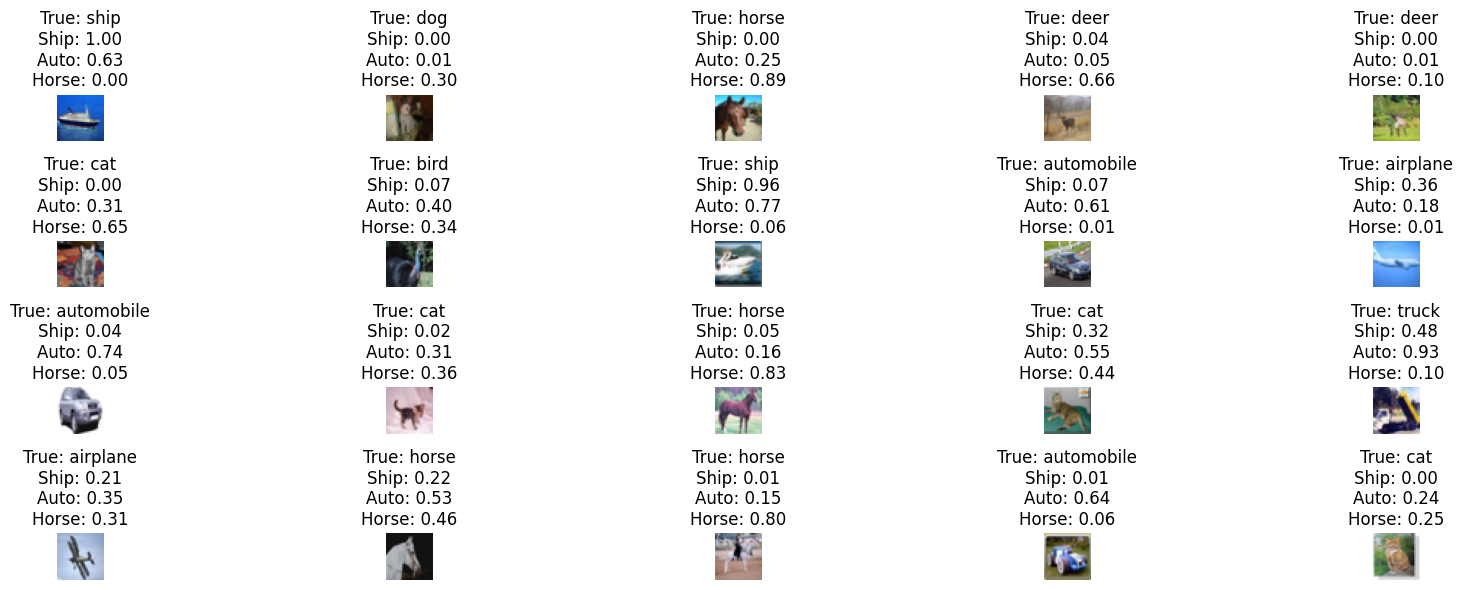

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load trained models
ship_model = tf.keras.models.load_model('ship_non_ship_cnn_model.keras')
auto_model = tf.keras.models.load_model('auto_non_auto_cnn_model.keras')
horse_model = tf.keras.models.load_model('horse_non_horse_cnn_model.keras')

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Token-based prediction function
def predict_with_token(image, token):
    image = np.expand_dims(image, axis=0)
    if token == 1:
        return ship_model.predict(image, verbose=0)[0][0]  # Probability of ship
    elif token == 2:
        return auto_model.predict(image, verbose=0)[0][0]  # Probability of automobile
    elif token == 3:
        return horse_model.predict(image, verbose=0)[0][0] # Probability of horse
    else:
        raise ValueError("Invalid token. Use 1 (ship), 2 (automobile), or 3 (horse).")

# Load CIFAR-10 data and normalize
(_, _), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype('float32') / 255.0
y_test = y_test.flatten()

# Select 100 random images (10 per class)
selected_indices = []
for i in range(10):
    class_indices = np.where(y_test == i)[0]
    selected_indices.extend(np.random.choice(class_indices, 10, replace=False))
selected_images = x_test[selected_indices]
selected_labels = y_test[selected_indices]

# Collect predictions
results = []
for i, (image, label) in enumerate(zip(selected_images, selected_labels)):
    prob_ship = predict_with_token(image, 1)
    prob_auto = predict_with_token(image, 2)
    prob_horse = predict_with_token(image, 3)
    results.append({
        'image_index': selected_indices[i],
        'true_label': class_names[label],
        'prob_ship': prob_ship,
        'prob_auto': prob_auto,
        'prob_horse': prob_horse,
        'true_ship': 1 if label == 8 else 0,
        'true_auto': 1 if label == 1 else 0,
        'true_horse': 1 if label == 7 else 0
    })

df = pd.DataFrame(results)

# Display 10 random images with their probabilities
np.random.seed(42)
sample_indices = np.random.choice(len(selected_images), 20, replace=False)
plt.figure(figsize=(18, 6))
for i, idx in enumerate(sample_indices):
    image = selected_images[idx]
    label = class_names[selected_labels[idx]]
    prob_ship = df.iloc[idx]['prob_ship']
    prob_auto = df.iloc[idx]['prob_auto']
    prob_horse = df.iloc[idx]['prob_horse']
    plt.subplot(4, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {label}\n"
              f"Ship: {prob_ship:.2f}\n"
              f"Auto: {prob_auto:.2f}\n"
              f"Horse: {prob_horse:.2f}")
plt.tight_layout()
plt.show()
